# Optimizing Track Cuts

**Goal:** I've done a lot of work trying to understand where the RNN / DIPS are limited, and I think it might be due to the track cuts that we're applying, so I decided to try to re-optimize this to see what kinds of performance gains we could see.

*However*, it might also be kind of interesting and fun to also see the performance of DIPS trained with the default options, but evaluated on the sample with more tracks.

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import * #myLSTM, myPFN
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Ok, so I was having some difficulties loading stuff into memory, so I'm just going to make my \$\$\$ plot loading in roc curves I've made previously.

In [21]:
baseSubDir = 'mc16d_PFlow_ttbar'
subDir_ip3d = baseSubDir + '_ip3d'
subDir_jf = baseSubDir + '_jf'

dataDir = "../../data"
modelDir = '../../models/'
figDir = '../../figures/'

nTrks = 40 
nFeatures = 13

dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTagTrain_ip3d = "3mtrain_15trks_{}".format(vStr)
dataTagTest_ip3d  = "2mtest_{}trks_{}_sd0_rev".format(15,vStr)
dataTagTrain   = "3mtrain_{}trks_{}".format(nTrks,vStr)
dataTagTest  = "2mtest_{}trks_{}_abs_sd0_rev".format(nTrks,vStr)

'''
Load in the X and ys for the ip3d cuts
'''
f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir_ip3d,dataTagTest_ip3d)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

lstm = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
              dataTag=dataTagTrain_ip3d+'_sd0_rev', 
              nHidden=100,loadModel=True,nClasses=3)

dips_ip3d = DIPS(ppm_sizes, dense_sizes, timeSteps=15, nFeatures=nFeatures,
                 modelDir=modelDir+subDir_ip3d, dataTag=dataTagTrain_ip3d, nClasses=3, loadModel=True, 
                 dropout=0,batch_norm=True)

Initialize method from myModel()
Building the baseline LSTM
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file


In [3]:
leffs, ceffs, beffs = [],[],[]

for m,subDir in zip([lstm,dips_ip3d],[subDir_ip3d,subDir_ip3d]):
    l,c,b = getEffs(m, X, y, ix, figDir=figDir,
                    subDir=subDir, modelDir=modelDir+subDir)
    leffs.append(l)
    ceffs.append(c)
    beffs.append(b)

../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file


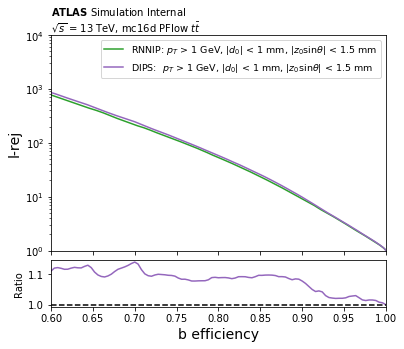

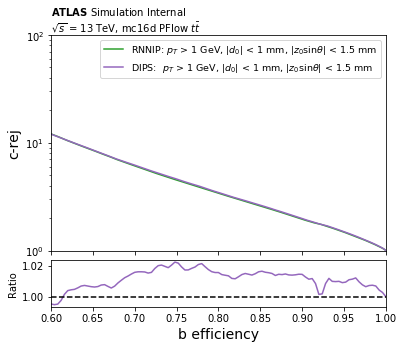

In [45]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

labels = [r"RNNIP: $p_T$ > 1 GeV, $|d_0|$ < 1 mm, $|z_0 \sin \theta|$ < 1.5 mm",
          r"DIPS:  $p_T$ > 1 GeV, $|d_0|$ < 1 mm, $|z_0 \sin \theta|$ < 1.5 mm"]

colors = ['C2','C4']

plotROCRatio(beffs, leffs, labels,text=text,colors=colors,
             legFontSize=9.5,ylabel='l-rej',ymax=1e4,
             figDir=figDir,subDir=subDir_ip3d,tag='lrej_cf_lstm')
plotROCRatio(beffs, ceffs, labels,text=text,colors=colors,
             legFontSize=9.5,ylabel='c-rej',ymax=100,
             figDir=figDir,subDir=subDir_ip3d,tag='crej_cf_lstm')

## $p_T$ impact

**Question:** How much of these gains are due to the lower $p_T$ threshold?

B/c in Run 3, they'll only be reconstructing tracks with $p_T > 1$ GeV.


pt: 1.0, d0: 3.5, z0: 5.0
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_pt_1.0_d0_3.5_z0_5.0/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


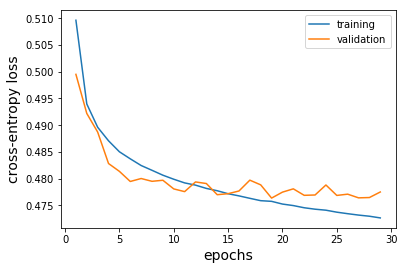

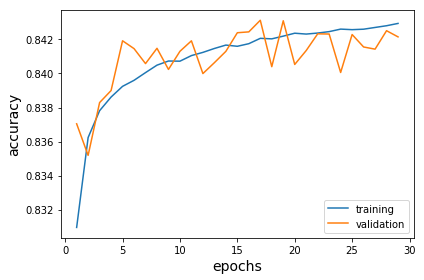

../../models/mc16d_PFlow_ttbar_pt_1.0_d0_3.5_z0_5.0/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
pt: 0.75, d0: 3.5, z0: 5.0
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_pt_0.75_d0_3.5_z0_5.0/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


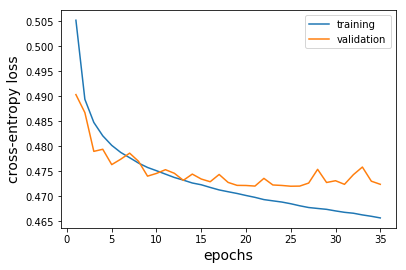

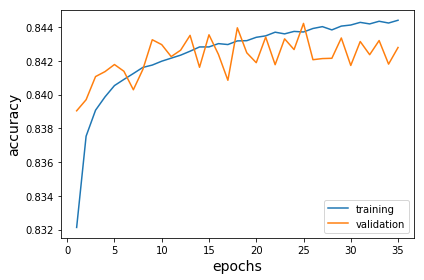

../../models/mc16d_PFlow_ttbar_pt_0.75_d0_3.5_z0_5.0/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
pt: 0.5, d0: 3.5, z0: 5.0
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_pt_0.5_d0_3.5_z0_5.0/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
acc
loss
val_acc
val_loss


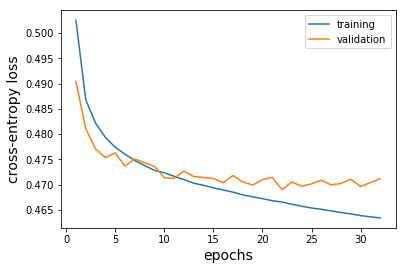

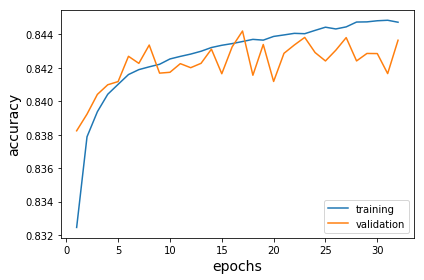

../../models/mc16d_PFlow_ttbar_pt_0.5_d0_3.5_z0_5.0/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_40trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file


In [70]:
Xs, ys, ixs = [],[],[]

tpt_cuts = [1.0,0.75,0.5]

for pt_cut in tpt_cuts: 
    for d0_cut in [3.5]: 
        for z0_cut in [5.0]: 
            
            print("pt: {}, d0: {}, z0: {}".format(pt_cut, d0_cut, z0_cut))
            
            # Load in the data
            trkTag = "_pt_{}_d0_{}_z0_{}".format(pt_cut,d0_cut,z0_cut)
            subDir = baseSubDir+trkTag
            
            f_name = "{}/{}/data_{}.hdf5".format(dataDir,subDir,dataTagTest)
            f = h5py.File(f_name,"r")

            Xs.append(f['X_test'][:])
            ys.append(f['y_test'][:])
            ixs.append(f['ix_test'][:])

            f.close()
                        
            # Load in the model
            dips = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
                        modelDir=modelDir+subDir, dataTag=dataTagTrain, nClasses=3, 
                        loadModel=True, dropout=0,batch_norm=True)
            
            if not os.path.exists(figDir+subDir):
                os.mkdir(figDir+subDir)
            
            # Evaluate
            trainingMetrics(dips.modelName, modelDir+subDir)
            leff, ceff, beff = getEffs(dips, Xs[-1], ys[-1], ixs[-1], figDir=figDir,
                                       subDir=subDir, modelDir=modelDir+subDir)

            leffs.append(leff)
            ceffs.append(ceff)
            beffs.append(beff)
            labels.append(r"DIPS:  $p_T$ > {} GeV, $|d_0|$ < {}, $|z_0 \sin \theta|$ < {}".format(pt_cut, d0_cut, z0_cut))
            

Overlay the curve comparing RNNIP, DIPS, and DIPS with looser JF cuts.

In [23]:
ltest = [np.sum(y==0)]*2 + [np.sum(ys[-1]==0)]*3
ctest = [np.sum(y==0)]*2 + [np.sum(ys[-1]==0)]*3

But, I decided not to include the ratio plots because I was having technical difficulties putting errors on the ratio plots.

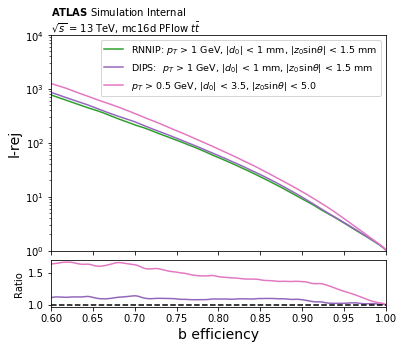

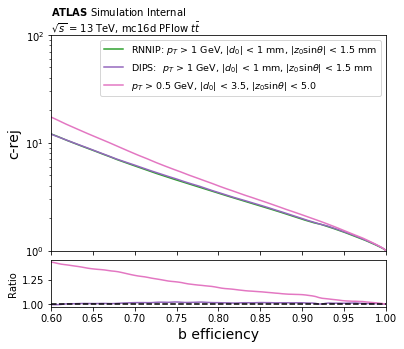

In [38]:
colors = ['C2','C4','C6']

plotROCRatio(beffs[:2] + [beffs[-1]], leffs[:2] + [leffs[-1]], 
             labels[:2] + [labels[-1]],
             text=text,colors=colors,
             #binomialErrors=True,nTest=ltest,rrange=(0.95,1.75),
             legFontSize=9.5,ylabel='l-rej',ymax=1e4,
             figDir=figDir,subDir=baseSubDir+'_jf',tag='lrej_cf_lstm')
plotROCRatio(beffs[:2] + [beffs[-1]], ceffs[:2] + [ceffs[-1]],
             labels[:2] + [labels[-1]],
             text=text,colors=colors,
             #binomialErrors=True,nTest=ctest,rrange=(0.95,1.45),
             legFontSize=9.5,ylabel='c-rej',ymax=100,
             figDir=figDir,subDir=baseSubDir+'_jf',tag='crej_cf_lstm')


Now compare the various cuts for DIPS.

In [88]:
short_labels = ["{}: $p_T$ > 1 GeV, ipxd IP cuts".format(tagger) for tagger in ["RNNIP","DIPS"]]
short_labels += ["DIPS: $p_T$ > {} GeV, jf IP cuts".format(tpt_cut) for tpt_cut in tpt_cuts]

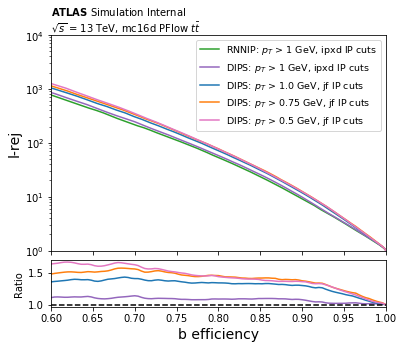

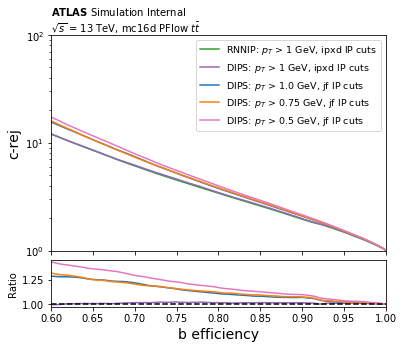

In [94]:
# Maybe take the RNN curve off this line?
colors = ['C2','C4','C0','C1','C6']

plotROCRatio(beffs, leffs, short_labels, text=text,colors=colors,
             #binomialErrors=True,nTest=ltest,rrange=(0.95,1.75),
             legFontSize=9.5,ylabel='l-rej',ymax=1e4,
             figDir=figDir,subDir=baseSubDir+'_jf',tag='lrej_vary_pt')
plotROCRatio(beffs, ceffs, short_labels,text=text,colors=colors,
             #binomialErrors=True,nTest=ctest,rrange=(0.95,1.45),
             legFontSize=9.5,ylabel='c-rej',ymax=100,
             figDir=figDir,subDir=baseSubDir+'_jf',tag='crej_vary_pt')

Sanity check: Make sure the DIPS values are what they say they are.

**Sanity check:** Let's make sure that the $p_T$ cuts that I implemented with the mask are working properly. To do this, I'm going to need to load in the scale file

In [8]:
jdf = pd.read_hdf("{}/mc16d_PFlow_ttbar_jf/jet_2mtest_40trks.h5".format(dataDir),key="jet_df")
txr = xr.open_dataarray('{}/mc16d_PFlow_ttbar_jf/trk_2mtest_40trks.nc'.format(dataDir))

In [9]:
tpts = []
nTrk_list = []

for tpt_cut, Xi in zip(tpt_cuts,Xs): 
    
    scalingfile = "{}/mc16d_PFlow_ttbar_pt_{}_d0_3.5_z0_5.0/scale_{}.json".format(dataDir,tpt_cut,dataTagTrain)
    with open(scalingfile, 'r') as varfile:
        d = json.load(varfile)
        
    mu, sigma = d['ptfrac']['mean'],d['ptfrac']['sd']

    print(mu,sigma)

    mask = getTrkMask(Xi)
    
    ptfrac = np.exp(mu + sigma * Xi[:,:,-4])
    tpt = (jdf.pt_orig.values.reshape(-1,1)*ptfrac)[mask]

    tpts.append(tpt)
    nTrk_list.append(np.sum(mask,axis=-1))

-2.757803013437859 0.9181672809266426
-2.875828611976767 0.9615768800134303
-3.040702926059751 1.0297803305901383


In [10]:
tpt_cuts

[1.0, 0.75, 0.5]

Histogram for the track $p_T$s.

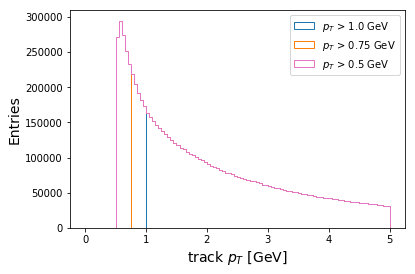

In [99]:
ylim = (0,300000)

for tpt_cut,tpt,c in zip(tpt_cuts, tpts, colors[-3:],):
    
    plt.hist(tpt, 100,(0,5), color=c,
             histtype='step',label="$p_T$ > {} GeV".format(tpt_cut))
        
plt.xlabel('track $p_T$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend()

_, ymax = plt.ylim()

plt.savefig("{}/{}/tpt_vary_pt.pdf".format(figDir,subDir_jf),bbox_inches='tight')

plt.show()

Histogram for the track multiplicities.

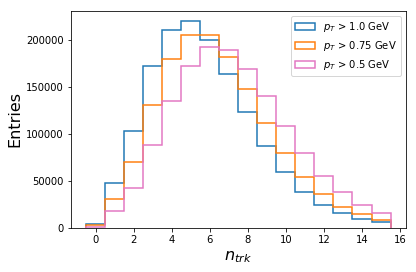

In [100]:
for tpt_cut,n,c in zip(tpt_cuts, nTrk_list, colors[-3:]):

    plt.hist(n, 16,(-0.5,15.5), color=c,histtype='step',linewidth=1.5,
             label="$p_T$ > {} GeV".format(tpt_cut))
    
plt.xlabel('$n_{trk}$',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.legend()

plt.savefig("{}/{}/nTrk_vary_pt.pdf".format(figDir,subDir_jf),bbox_inches='tight')

plt.show()

Overlay with the tracks used by ip3d as well.

In [48]:
for l in labels[1:]:
    print(l)

DIPS:  $p_T$ > 1 GeV, $|d_0|$ < 1 mm, $|z_0 \sin \theta|$ < 1.5 mm
DIPS: $p_T$ > 1.0 GeV, $|d_0|$ < 3.5, $|z_0 \sin \theta|$ < 5.0
DIPS: $p_T$ > 0.75 GeV, $|d_0|$ < 3.5, $|z_0 \sin \theta|$ < 5.0
DIPS: $p_T$ > 0.5 GeV, $|d_0|$ < 3.5, $|z_0 \sin \theta|$ < 5.0


In [55]:
colors

['C2', 'C4']

5.2074386666666665
5.850016666666667
6.496031333333334
7.3796973333333336


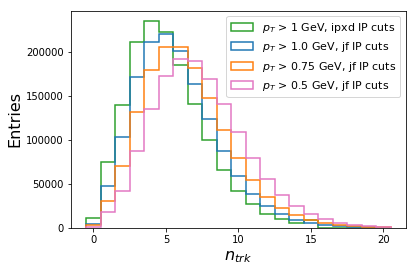

In [103]:
# Overlay with the number of tracks used by ip3d as well
n_ip3d = np.sum(getTrkMask(X),axis=-1)
print(np.mean(n_ip3d))
plt.hist(n_ip3d, 21,(-0.5,20.5), color='C2',histtype='step',linewidth=1.5,
             label="$p_T$ > 1 GeV, ipxd IP cuts")
   
for tpt_cut,n,c in zip(tpt_cuts, nTrk_list, colors[-3:]):

    print(np.mean(n))
    plt.hist(n, 21,(-0.5,20.5), color=c,histtype='step',linewidth=1.5,
             label="$p_T$ > {} GeV, jf IP cuts".format(tpt_cut))
    
plt.xlabel('$n_{trk}$',fontsize=16)
plt.ylabel('Entries',fontsize=16)
plt.legend(fontsize=11)

plt.savefig("{}/{}/nTrk_vary_pt_with_ip3d.pdf".format(figDir,subDir_jf),bbox_inches='tight')

plt.show()

Last sanity check: I want to check that the track $p_t$ and track multiplicity plots are the same if I get the info directly from the xarray with the track cuts.

In [13]:
X_jf = txr.values
txr_mask = getTrkMask(X_jf)
txr_pt = txr.loc[:,:,'pt'].values[txr_mask]
txr_nTrk = np.sum(txr_mask,axis=-1)

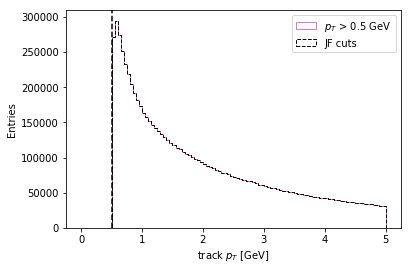

In [14]:
plt.hist(tpts[-1], 100,(0,5), color=colors[-1],
         histtype='step',label="$p_T$ > {} GeV".format(tpt_cuts[-1]))
plt.hist(txr_pt, 100,(0,5), color='k',linestyle='--',
         histtype='step',label="JF cuts")

ylim = plt.ylim()
plt.plot([tpt_cuts[-1]]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('track $p_T$ [GeV]')
plt.ylabel('Entries')
plt.legend()

plt.show()

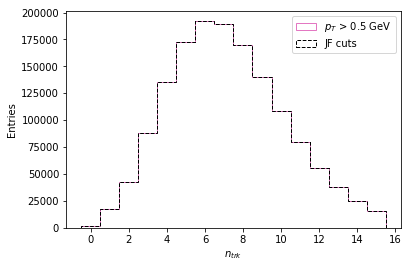

In [15]:
plt.hist(nTrk_list[-1], 16,(-0.5,15.5), color=colors[-1],histtype='step',
         label="$p_T$ > {} GeV".format(tpt_cuts[-1]))
plt.hist(txr_nTrk,16,(-0.5,15.5), color='k',linestyle='--',
         histtype='step',label="JF cuts")
    
plt.xlabel('$n_{trk}$')
plt.ylabel('Entries')
plt.legend()

plt.show()

Ok, I have confidence that I trust this study now!